# MyoPS 2020 Challenge

End-to-end, multi-channel, focal loss, all classes, cropped

In [2]:
!pip install fastai2

     |████████████████████████████████| 194kB 7.0MB/s 


In [1]:
!pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

  Cloning https://github.com/Project-MONAI/MONAI to /tmp/pip-install-5g2j069m/MONAI
  Running command git clone -q https://github.com/Project-MONAI/MONAI /tmp/pip-install-5g2j069m/MONAI
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for MONAI: filename=monai-0.2.0+34.g267407f-cp36-none-any.whl size=221955 sha256=cc12d0f84aafcc12e9d841763183ac6409549e6aef5b5e08a37ffb6511f36563
  Stored in directory: /tmp/pip-ephem-wheel-cache-09_6xkvm/wheels/32/e1/f2/9985050c97af405af0c840d4b9fc44324fdf0c92fe03de697f
Successfully built MONAI


In [3]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

In [4]:
import nibabel as nib
from tqdm.notebook import tqdm

### fastai U-Net on these static images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
path = "/content/drive/My Drive/miccai2020/myops/png_with_clahe"

In [7]:
np.random.seed(42)
ids = np.arange(101,126)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,5))
ids

array([[109, 117, 101, 124, 112],
       [110, 114, 102, 123, 106],
       [103, 113, 116, 104, 105],
       [121, 118, 122, 119, 125],
       [108, 111, 115, 120, 107]])

In [16]:
def get_train_images(path):
  return L([x for x in get_image_files(path) if x.name.startswith('1')])

Use cropping instead of resizing

In [18]:
myopsDlsCV2 = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
    get_items=get_train_images,
    splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in ids[2]),
    get_y=lambda o: str(o).replace("images","masks"),
    item_tfms=CropPad(256),
    batch_tfms=aug_transforms(max_rotate=90,pad_mode='zeros')).dataloaders(f'{path}/images',num_workers=8,batch_size=16)

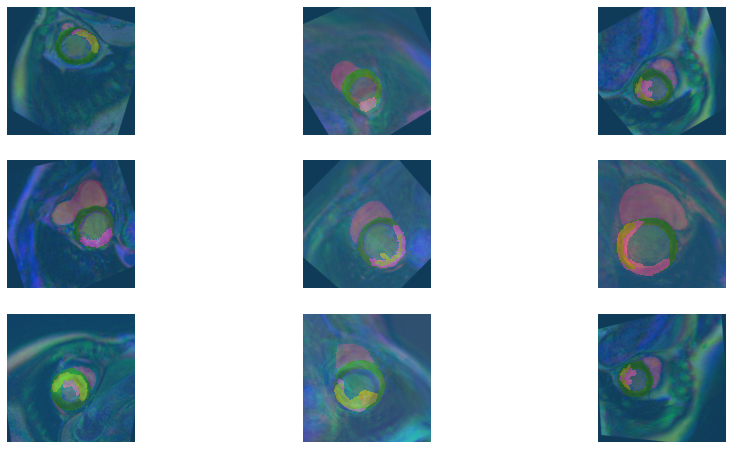

In [19]:
myopsDlsCV2.show_batch(figsize=(15,8))

In [20]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [21]:
monaiFocal = FocalLoss(weight=torch.Tensor([.1,.1,.1,.1,.3,.3]),reduction='mean')
def myFocal(input, target):
  return monaiFocal(input, target.unsqueeze(1))

In [22]:
learn = unet_learner(
  myopsDlsCV2,
  resnet34,
  loss_func=myFocal,
  metrics=[foreground_acc, *dices]
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.045560,0.032202,0.026722,0.067735,0.000009,0.067389,0.109816,0.202212,01:16
1,0.039790,0.036518,0.005769,0.030134,0.000000,0.000000,0.105263,0.263158,00:25
2,0.034891,0.021846,0.260100,0.450370,0.312168,0.181881,0.068296,0.186405,00:25
3,0.029904,0.023113,0.322053,0.726898,0.398838,0.077497,0.107618,0.236077,00:25
4,0.027954,0.026766,0.263249,0.602261,0.166055,0.103065,0.141866,0.218213,00:25


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.018954,0.016734,0.496146,0.677336,0.544421,0.404971,0.182908,0.204755,00:27
1,0.016710,0.012822,0.624111,0.690841,0.559858,0.694367,0.212543,0.160304,00:26
2,0.014978,0.013893,0.579663,0.597283,0.548959,0.664504,0.197828,0.194436,00:26
3,0.013704,0.010930,0.700397,0.764664,0.575695,0.784021,0.148906,0.260019,00:26
4,0.013095,0.012558,0.743163,0.773302,0.572094,0.741566,0.140387,0.247098,00:26
5,0.012275,0.011389,0.691749,0.765645,0.527041,0.793973,0.194962,0.276585,00:26
6,0.011420,0.010577,0.751364,0.773485,0.637517,0.795748,0.180019,0.291014,00:26
7,0.010657,0.010519,0.694733,0.746896,0.551478,0.815017,0.171845,0.286350,00:26
8,0.010042,0.009855,0.690410,0.789042,0.574963,0.811909,0.190306,0.317000,00:26
9,0.009521,0.010962,0.737657,0.806759,0.572281,0.803885,0.205911,0.272414,00:26


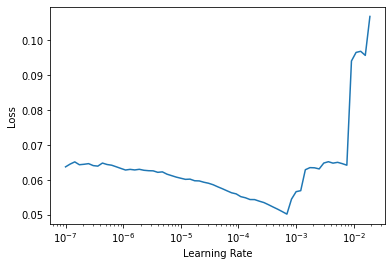

In [23]:
learn = unet_learner(
  myopsDlsCV2,
  resnet34,
  loss_func=myFocal,
  metrics=[foreground_acc, *dices]
)
learn.lr_find()
learn.fine_tune(15, base_lr=1e-3, freeze_epochs=5)

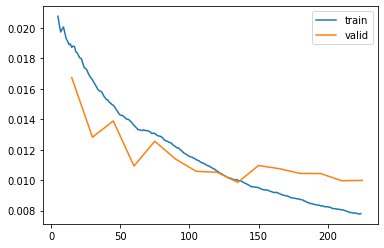

In [28]:
learn.recorder.plot_loss()

In [ ]:
learn.path = Path(path).parent

In [29]:
# For some reason export does not work -> use save instead
learn.save('allClasses_multiChannel_clahe_crop256_focal3_cv2_5_15.pkl')

#### Try with longer training time

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.086475,0.054674,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,00:25
1,0.063809,0.041354,0.000000,0.000000,0.000000,0.000000,0.017544,0.263158,00:25
2,0.051530,0.032322,0.099388,0.222735,0.009710,0.142478,0.112983,0.158445,00:25
3,0.042282,0.031079,0.132778,0.374738,0.093014,0.067610,0.089598,0.260401,00:25
4,0.035345,0.021833,0.407400,0.527945,0.441649,0.367362,0.126224,0.176290,00:25
5,0.029520,0.018391,0.625193,0.684917,0.458444,0.703915,0.195782,0.128749,00:25
6,0.025297,0.014983,0.568087,0.556411,0.517311,0.724695,0.134248,0.187693,00:25
7,0.022556,0.016909,0.432540,0.763397,0.524100,0.197292,0.134487,0.196754,00:25
8,0.022089,0.017192,0.422539,0.561749,0.440872,0.449196,0.130876,0.206744,00:25
9,0.019785,0.016113,0.493827,0.570969,0.379062,0.601789,0.227642,0.168213,00:25


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.010998,0.011573,0.667823,0.722239,0.500578,0.793158,0.169279,0.239391,00:26
1,0.010513,0.011145,0.657388,0.722353,0.577107,0.789328,0.133286,0.258724,00:26
2,0.010417,0.012231,0.638732,0.695907,0.572349,0.766703,0.169976,0.229808,00:26
3,0.010737,0.012601,0.685805,0.785227,0.422917,0.789344,0.231325,0.159877,00:26
4,0.010452,0.011326,0.639815,0.677092,0.591728,0.773223,0.184364,0.250669,00:26
5,0.010100,0.010635,0.727153,0.811020,0.600879,0.799615,0.181608,0.233323,00:26
6,0.009713,0.009890,0.728393,0.771216,0.558438,0.810403,0.189846,0.305141,00:26
7,0.009330,0.009747,0.732361,0.854948,0.589324,0.825259,0.189195,0.271521,00:26
8,0.009006,0.010719,0.654051,0.768525,0.631078,0.730246,0.139128,0.389580,00:26
9,0.008685,0.010292,0.723572,0.825115,0.653583,0.801167,0.195780,0.262388,00:26


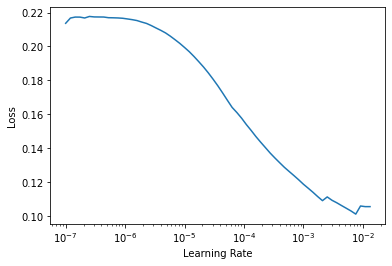

In [30]:
learn = unet_learner(
  myopsDlsCV2,
  resnet34,
  loss_func=myFocal,
  metrics=[foreground_acc, *dices]
)
learn.lr_find()
learn.fine_tune(20, base_lr=1e-3, freeze_epochs=10)

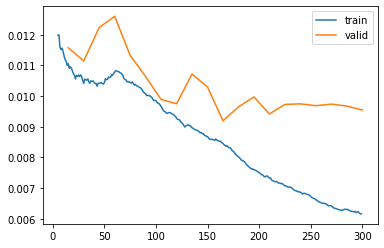

In [31]:
learn.recorder.plot_loss()

In [35]:
learn.save('allClasses_multiChannel_clahe_crop256_focal3_cv2_10_20.pkl')

#### Compare to same setup without clahe

In [32]:
myopsDlsCV2NoClahe = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
    get_items=get_train_images,
    splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in ids[2]),
    get_y=lambda o: str(o).replace("images","masks"),
    item_tfms=CropPad(256),
    batch_tfms=aug_transforms(max_rotate=90,pad_mode='zeros')).dataloaders('/content/drive/My Drive/miccai2020/myops/png/images',num_workers=8,batch_size=16)

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.055638,0.047202,0.000000,0.000000,0.000000,0.000000,0.105263,0.228070,01:03
1,0.044539,0.027436,0.219618,0.590590,0.013426,0.207081,0.106024,0.109268,00:24
2,0.036528,0.021775,0.574736,0.659818,0.378063,0.638784,0.137840,0.114835,00:24
3,0.030557,0.014252,0.630357,0.758251,0.514144,0.742334,0.149055,0.198406,00:25
4,0.025938,0.016853,0.465883,0.675690,0.484952,0.462015,0.121120,0.226014,00:25
5,0.022910,0.013052,0.592007,0.717739,0.606983,0.633525,0.169511,0.239883,00:25
6,0.020508,0.012143,0.612892,0.807613,0.557768,0.684421,0.101902,0.298608,00:25
7,0.018630,0.011988,0.668275,0.820089,0.594707,0.732621,0.113377,0.243769,00:25
8,0.016936,0.015055,0.652055,0.809824,0.253172,0.782705,0.194376,0.160322,00:25
9,0.016819,0.016301,0.604814,0.734016,0.329109,0.710313,0.143503,0.136513,00:25


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.011705,0.011254,0.678884,0.772710,0.519975,0.802309,0.127759,0.266216,00:26
1,0.010960,0.011122,0.660498,0.776521,0.538131,0.782194,0.094270,0.285895,00:25
2,0.010545,0.011092,0.731660,0.802954,0.633863,0.809248,0.112925,0.319614,00:26
3,0.010404,0.009966,0.696559,0.834332,0.656561,0.782185,0.136834,0.326768,00:26
4,0.010188,0.009786,0.709672,0.833297,0.574571,0.833493,0.191369,0.232957,00:25
5,0.010114,0.010758,0.766079,0.839259,0.694867,0.798996,0.157916,0.329691,00:26
6,0.009899,0.010401,0.727391,0.837906,0.648391,0.830437,0.154644,0.315750,00:26
7,0.009708,0.009728,0.734118,0.838506,0.636800,0.832002,0.142648,0.369358,00:25
8,0.009395,0.010810,0.757059,0.835547,0.652556,0.827522,0.127306,0.316848,00:25
9,0.008952,0.009937,0.771129,0.849285,0.659565,0.835357,0.206798,0.323612,00:26


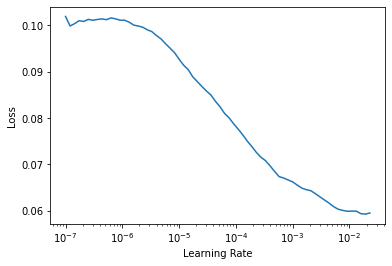

In [33]:
learnNoClahe = unet_learner(
  myopsDlsCV2NoClahe,
  resnet34,
  loss_func=myFocal,
  metrics=[foreground_acc, *dices]
)
learnNoClahe.lr_find()
learnNoClahe.fine_tune(20, base_lr=1e-3, freeze_epochs=10)

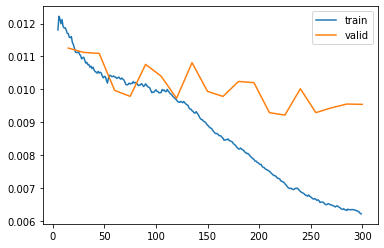

In [34]:
learnNoClahe.recorder.plot_loss()

In [36]:
learnNoClahe.path = Path(path).parent
learnNoClahe.save('allClasses_multiChannel_crop256_focal3_cv2_10_20.pkl')

# Predictions for original images

In [ ]:
outdir = f'{path}/../pred/allClasses_multiChannel_crop256_focal3_cv2_15_15'
os.makedirs(outdir, exist_ok=True)

In [ ]:
mapping = torch.LongTensor([0, 500, 200, 600, 1220, 2221])

for id in tqdm(np.arange(101,126)):
  origs = sorted(glob.glob(f"{path}/images/{id}-orig-*.png"))
  masks = []
  for o in origs:
    image = PILImage.create(o)
    mask = PILMask.create(learn.predict(o)[0].argmax(dim=0).byte()).crop_pad((image.shape[1],image.shape[0]))
    mask = mapping.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
    masks.append(mask.to(torch.int32))
  masks = np.stack(masks,axis=2)
  nifti = nib.load(f'{path}/../train25_myops_gd/myops_training_{id}_gd.nii.gz')
  nifti_pred = nib.Nifti1Image(masks, nifti.affine, nifti.header)
  nib.save(nifti_pred, f'{outdir}/myops_test_{id}_seg.nii.gz')

In [ ]:
origs

[]

# Experiments

In [ ]:
result = learn.get_preds()

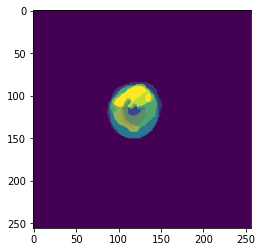

In [ ]:
plt.imshow(result[0][0].argmax(dim=0))
plt.imshow(result[1][0], alpha=.5)

In [ ]:
origs = glob.glob(f"{path}/images/*orig*")

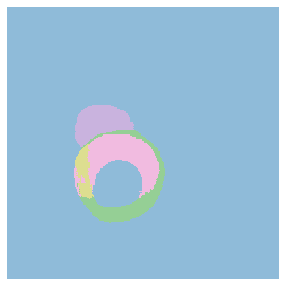

In [ ]:
learn.predict(origs[0])[0].argmax(dim=0).show()

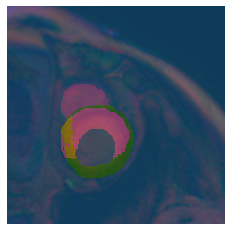

In [ ]:
fig,ax = plt.subplots()
PILImage(PILImage.create(origs[0]).crop_pad(256)).show(ax=ax)
learn.predict(origs[0])[0].argmax(dim=0).show(ax=ax)

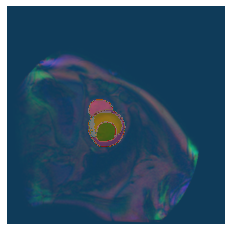

In [ ]:
fig,ax = plt.subplots()
image = PILImage.create(origs[0])
image.show(ax=ax)
mask = PILMask(PILMask.create(learn.predict(origs[0])[0].argmax(dim=0).byte()).crop_pad(image.shape))
mask.show(ax=ax)

In [ ]:
np.unique(learn.predict(origs[0])[0].argmax(dim=0), return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([58343,  1635,  1523,  1359,  2190,   486]))

In [ ]:
np.unique(image2tensor(mask).numpy(),return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([253928,   1635,   1523,   1359,   2190,    486]))

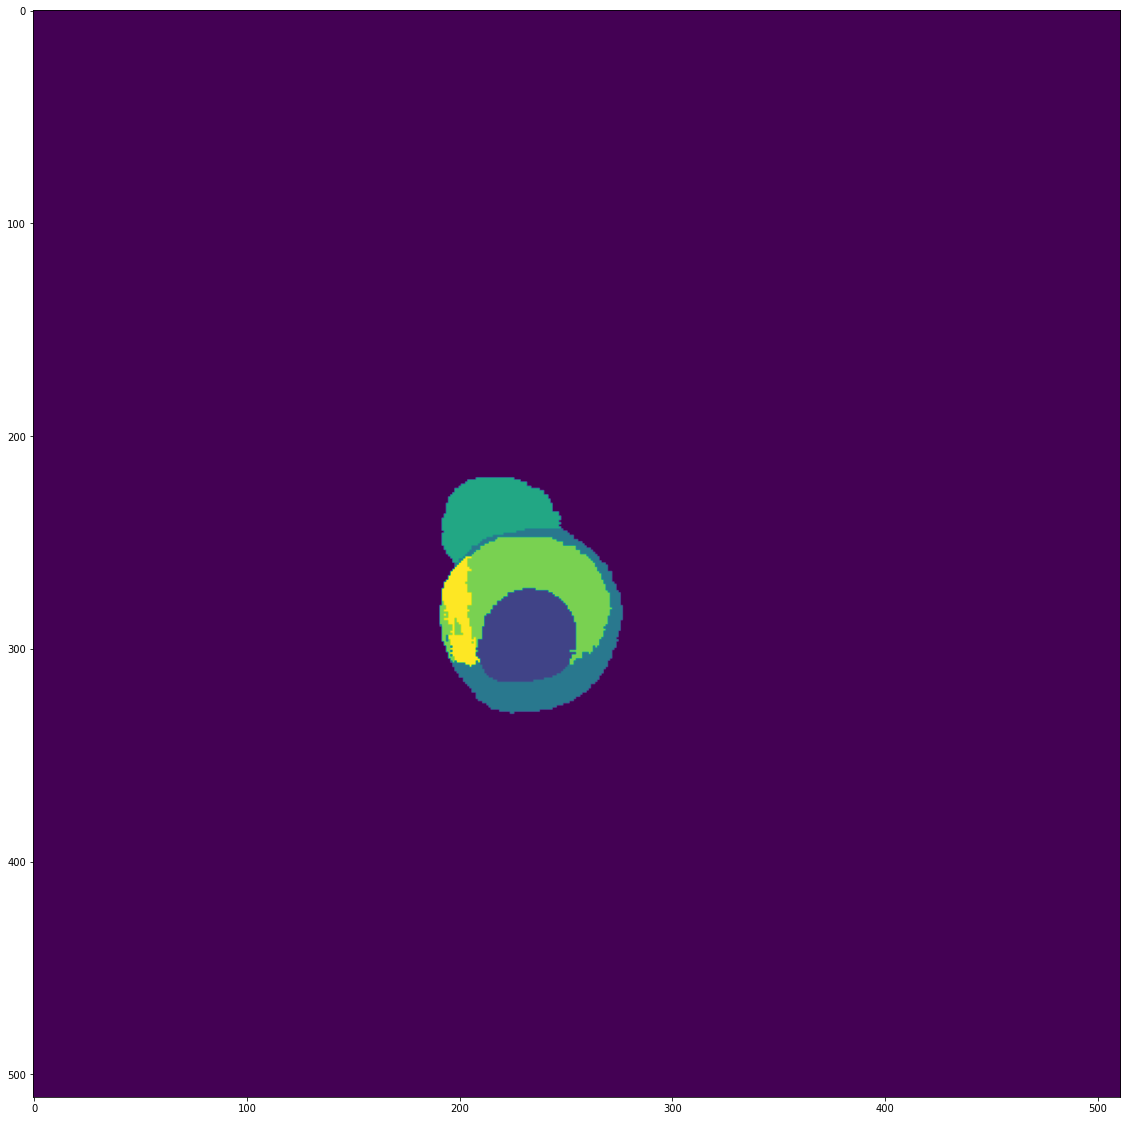

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image2tensor(mask).numpy()[0])

In [ ]:
nifti102 = np.asanyarray(nib.load(f'{path}/../train25_myops_gd/myops_training_102_gd.nii.gz').dataobj)

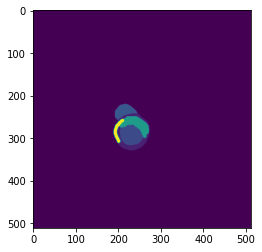

In [ ]:
plt.imshow(nifti102[:,:,0])

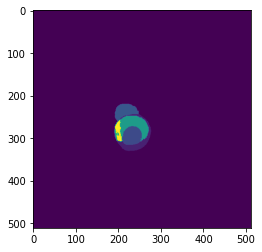

In [ ]:
# (LV) blood pool (labelled 500), right ventricular blood pool (600), LV normal myocardium (200), LV myocardial edema (1220), LV myocardial scars (2221)
mapping = torch.LongTensor([0, 500, 200, 600, 1220, 2221])
mask = PILMask.create(learn.predict(origs[0])[0].argmax(dim=0).byte()).crop_pad(image.shape)
mask = mapping.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
plt.imshow(mask)

In [ ]:
origs[0]

'/content/drive/My Drive/miccai2020/myops/png/images/102-orig-0.png'

In [ ]:
mask.to(torch.int32).numpy().dtype

dtype('int32')

In [ ]:
origs = sorted(glob.glob(f"{path}/images/102-orig-*.png"))

In [ ]:
masks = []
for o in origs:
  mapping = torch.LongTensor([0, 500, 200, 600, 1220, 2221])
  mask = PILMask.create(learn.predict(o)[0].argmax(dim=0).byte()).crop_pad(image.shape)
  mask = mapping.index_select(0,image2tensor(mask).flatten().to(torch.long)).reshape(*mask.shape)
  masks.append(mask.to(torch.int32))
masks = np.stack(masks,axis=2)

In [ ]:
masks.shape

(511, 511, 3)

In [ ]:
nifti102.shape

(511, 511, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


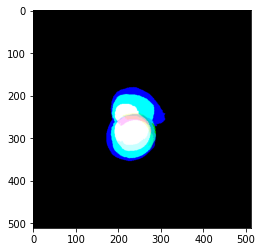

In [ ]:
plt.imshow(masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


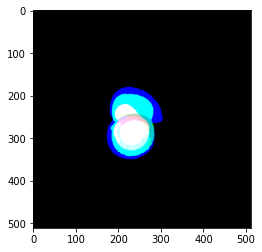

In [ ]:
plt.imshow(nifti102)

In [ ]:
nifti102_raw = nib.load(f'{path}/../train25_myops_gd/myops_training_102_gd.nii.gz')

In [ ]:
nifti102_pred = nib.Nifti1Image(masks, nifti102_raw.affine, nifti102_raw.header)

In [ ]:
nib.save(nifti102_pred, f'{outdir}/myops_test_102_seg.nii.gz')